In [ ]:
pip install PyPortfolioOpt

In [ ]:
from pandas_datareader import data as web      # pandas_datareader este o metoda ce permite stocarea de date din diverse surse online.
import numpy as np        # numpy este o librarie ce permite stocarea si manipularea datelor in matrice multidimensionale.
import pandas as pd   # pandas este o librarie utilizata pentru analiza si manipularea datelor.
from datetime import datetime  # datetime este o metoda folosita pentru a actualiza ziua de azi.
import matplotlib.pyplot as plt # matplotlib este o librarie folosita pentru realizarea graficelor.
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, base_optimizer, objective_functions# metoda risk_models oferă funcții pentru estimarea matricei de covarianță bazate pe randamente istorice.
from pypfopt import expected_returns, EfficientSemivariance # metoda expected_returns furnizeaza functii de estimare a profitului asteptat.
from pypfopt import EfficientCVaR
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.hierarchical_portfolio import HRPOpt
import statistics
import math

In [ ]:
class Price: #stocheaza pretul de la o data anume
  def __init__(obj, date, value):
    obj.date = date #data
    obj.value = value #pret

class Asset: #stocheaza stock-ul: numele, preturile pe zile, ponderea in portofoliu si numarul de unitati cumparate
  def __init__(obj, name, weight, prices, initial_value = 10000):
    obj.name = name 
    obj.weight = weight
    obj.prices = prices
    obj.units =  initial_value * weight / prices[0].value 

  
  def replace_weight_with_units(obj, no_of_units = 0):
    obj.units = no_of_units

class Portfolio: #stocheaza portofoliul rezultat dupa aplicarea modelelor
  def __init__(obj, strategy, assets, start_date, end_date, initial_value = 10000):
    obj.strategy = strategy #numele strategiei folosite
    obj.assets = assets #activele folosite, fiecare continand preturile zilnice, numarul de unitati si ponderea in portfoliu
    #data la care se face cumpararea si data pana la care se calculeaza valoarea portofoliului
    obj.start_date = start_date
    obj.end_date = end_date
    obj.initial_value = initial_value #valoarea investita initial
    obj.current_value = []
    obj.current_value = obj.getValue() #valoarea zilnica a portofliului intre data la care s-a facut cumpararea si data finala
    obj.daily_procentual_change = obj.get_daily_procentual_change()

  def getValue(obj): # functie folosita pentru a calcula valoarea zilnica a portfoliului, in functie de preturile activelor, ponderile lor in portofoliu si numarul de unitati cumparate
    curr_values = []
    for idx in range(0, len(obj.assets[0].prices)): #for pentru data
      total_value = 0
      curr_date = obj.assets[0].prices[idx].date
      for stock in obj.assets:
        curr_val = stock.prices[idx].value * stock.units
        total_value += curr_val
      curr_values.append(Price(curr_date, total_value))
    
    return curr_values
  
  def get_daily_procentual_change(obj):
    daily_procentual_change = []
    for idx in range(1, len(obj.current_value)): #for pentru data
      date_fluct = ((obj.current_value[idx].value - obj.current_value[idx - 1].value) * 100) / obj.current_value[idx - 1].value
      daily_procentual_change.append(Price(obj.current_value[idx].date, date_fluct))
    return daily_procentual_change



In [ ]:
def compute_portfolio(assets, start_date, end_date, weights, technique): 
    df = pd.DataFrame()
    for stock in assets:
      df[stock] = web.DataReader(stock, data_source= 'yahoo' , start = start_date, end = end_date)['Adj Close']

    cleaned_weights = None

    if technique == 'MV': 
      mu = expected_returns.mean_historical_return(df)   
      S = risk_models.risk_matrix(df, method= 'sample_cov')
      ef = EfficientFrontier(mu, S)
      ef.add_objective(objective_functions.L2_reg, gamma=1) 
      weights = ef.efficient_return(0.25)
      cleaned_weights = ef.clean_weights() 
      ef.portfolio_performance(verbose=True) 
      latest_prices = get_latest_prices(df)
      da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
      allocation, leftover = da.greedy_portfolio()
    elif technique == 'CVAR':
      mu = expected_returns.mean_historical_return(df) 
      historical_returns = expected_returns.returns_from_prices(df)
      es = EfficientCVaR(mu, historical_returns)
      es.add_objective(objective_functions.L2_reg, gamma=1)
      weights = es.efficient_risk(0.2)
      cleaned_weights = es.clean_weights()
      es.portfolio_performance(verbose=True)
      latest_prices = get_latest_prices(df)
      da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
      allocation, leftover = da.greedy_portfolio()
    elif technique == 'MSV':
      mu = expected_returns.mean_historical_return(df)
      historical_returns = expected_returns.returns_from_prices(df)
      es = EfficientSemivariance(mu, historical_returns)
      weights = es.efficient_risk(0.10)
      cleaned_weights = es.clean_weights()
      es.portfolio_performance(verbose=True)
      latest_prices = get_latest_prices(df)
      da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
      allocation, leftover = da.greedy_portfolio()
    elif technique == 'HRP':
      mu = expected_returns.mean_historical_return(df) # mean_historical_return calculeaza randamentul istoric mediu anualizat.
      historical_returns = expected_returns.returns_from_prices(df)
      es = HRPOpt(historical_returns)
      weights = es.optimize()
      cleaned_weights = es.clean_weights()
      es.portfolio_performance(verbose=True)
      latest_prices = get_latest_prices(df)
      da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
      allocation, leftover = da.greedy_portfolio()
    elif technique == '1/N':
      cleaned_weights = {}
      weight = 1 / len(assets)
      for stock in assets:
        cleaned_weights[stock] = weight  
      latest_prices = get_latest_prices(df)
      da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
      allocation, leftover = da.greedy_portfolio()

    # Pie chart 

    labels = list(cleaned_weights.keys())  # cleaned_weights este un OrderedDict deci keys() va returna numele activelor.
    values = list(cleaned_weights.values())  # values() va returna ponderile
    not_null_labels = []
    not_null_values = []

    for index in range(len(labels)):
      if values[index] > 0.0:
        not_null_labels.append(labels[index])
        not_null_values.append(values[index])

    print("Allocation:")
    print(allocation, leftover)
    fig1, ax1 = plt.subplots()
    ax1.pie(not_null_values, labels=not_null_labels, autopct='%1.1f%%')
    ax1.axis('equal')  # axis('equal') asigura forma perfect rotunda
    plt.show()

    return df, cleaned_weights, allocation


Expected annual return: 25.0%
Annual volatility: 13.7%
Sharpe Ratio: 1.68
Allocation:
{'AMT': 28, 'QQQ': 12, 'GLD': 6, 'AGG': 3} 31.683311462402344


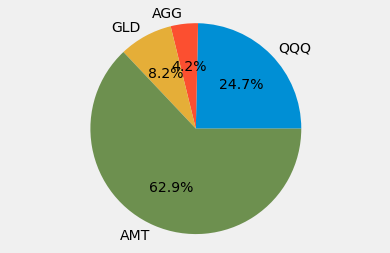

Expected annual return: 13.1%
Conditional Value at Risk: 10.04%
Allocation:
{'AMT': 12, 'QQQ': 8, 'GLD': 9, 'AGG': 12, 'VEA': 27, 'VWO': 23, 'BLOK': 48} 13.33816909790039


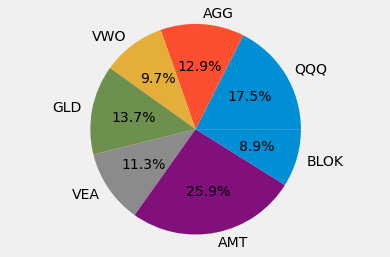

Expected annual return: 27.1%
Annual semi-deviation: 10.0%
Sortino Ratio: 2.51
Allocation:
{'AMT': 33, 'QQQ': 8, 'GLD': 6} 86.0404052734375


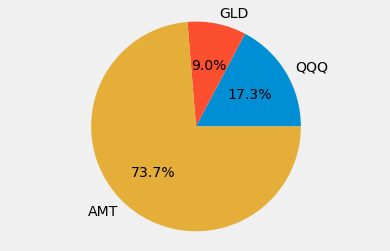

Expected annual return: 6.4%
Annual volatility: 3.0%
Sharpe Ratio: 1.47
Allocation:
{'AGG': 77, 'GLD': 4, 'BLOK': 13, 'AMT': 1, 'VEA': 4, 'VWO': 4, 'QQQ': 1} 10.177854537963867


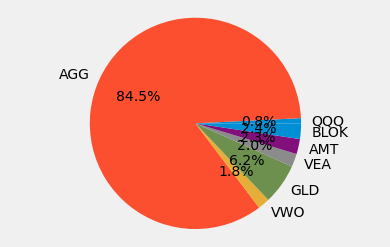

Allocation:
{'QQQ': 7, 'AGG': 13, 'VWO': 33, 'GLD': 10, 'VEA': 34, 'AMT': 6, 'BLOK': 78} 30.636402130126953


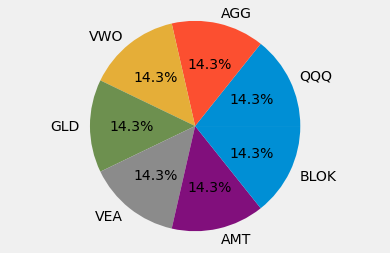

In [ ]:
assets = [['QQQ', 'AGG', 'VWO', 'GLD', 'VEA', 'AMT', 'BLOK'], 
          ['QQQ', 'AGG', 'VWO', 'GLD', 'VEA', 'AMT', 'BLOK'], 
          ['QQQ', 'AGG', 'VWO', 'GLD', 'VEA', 'AMT', 'BLOK'], 
          ['QQQ', 'AGG', 'VWO', 'GLD', 'VEA', 'AMT', 'BLOK'], 
          ['QQQ', 'AGG', 'VWO', 'GLD', 'VEA', 'AMT', 'BLOK'] ]
weights = [np.array([0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14]), 
           np.array([0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14]), 
           np.array([0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14]), 
           np.array([0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14]), 
           np.array([0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14])]
techniques = ['MV', 'CVAR', 'MSV', 'HRP', '1/N', 'MV', 'CVAR', 'MSV', 'HRP', '1/N']
start_date = "2018-03-17" 
portfolio_names = ['MV-ETF', 'CVAR-ETF', 'MSV-ETF', 'HRP-ETF', '1/N-ETF']
end_date = "2020-01-01"

df_list = []
cleaned_weights_list = []
allocations = []

for index in range(len(assets)):
  result = compute_portfolio(assets[index],start_date, end_date, weights[index], techniques[index])
  df_list.append(result[0])
  cleaned_weights_list.append(result[1])
  allocations.append(result[2])



In [ ]:
portfolios = []
future_stock_start_date = "2020-01-02"
today = datetime.today().strftime('%Y-%m-%d')

for index in range(len(df_list)): #pentru fiecare portofoliu
  new_assets = [] # lista de stock uri pe care o voi popula
  df = df_list[index] #portofoliul curent
  cleaned_weights = cleaned_weights_list[index] #weight-urile corespunzatoare portofoliului curent
  df_future = pd.DataFrame()
  for stock in assets[index]: #pentru fiecare stock din portofoliul curent
    prices = []    
    df_future[stock] = web.DataReader(stock, data_source= 'yahoo' , start = future_stock_start_date, end = today)['Adj Close'] #preiau preturile fiecarui stock
    
    for idx in range(0, len(df_future[stock].index)):   #pentru fiecare zi intre future_stock_start_date si today
      prices.append(Price(df_future[stock].index[idx], df_future[stock][df_future[stock].index[idx]])) #adaug in lista de prices pretul din acea zi si data

    asset = Asset(df[stock].name, cleaned_weights.get(df[stock].name), prices, 10000) #creez obiectul de tip asset corespunzator stock ului curent, utilizand si lista de prices tocmai calculataa
    
    if df[stock].name in allocations[index]: #daca asset ul este folosit in portofoliu (se cumpara actiuni)
      asset.replace_weight_with_units(allocations[index][df[stock].name]) # ma opresc din a folosi weight-ul pentru calculul veniturilor, inlocuindu-l xu numarul de actiuni
    else:
      asset.replace_weight_with_units(0) # daca nu se cumpara actiuni, definesc numarul de actiuni cumparate ca fiind zero
    new_assets.append(asset)

  portfolios.append(Portfolio(portfolio_names[index], new_assets, future_stock_start_date, today, 10000)) #creez obiectul de  tip portofoliu, care contine si lista de asset-uri tocmai definita

In [ ]:
benchmark = web.DataReader('SPY', data_source= 'yahoo' , start = future_stock_start_date, end = today)['Adj Close']


prices = [] 
new_assets = []
for idx in range(0, len(benchmark.index)):   
  prices.append(Price(benchmark.index[idx], benchmark[benchmark.index[idx]]))
asset = Asset(benchmark.name, 1, prices, 10000)
new_assets.append(asset)
portfolios.append(Portfolio(portfolio_names[index], new_assets, future_stock_start_date, today, 10000))

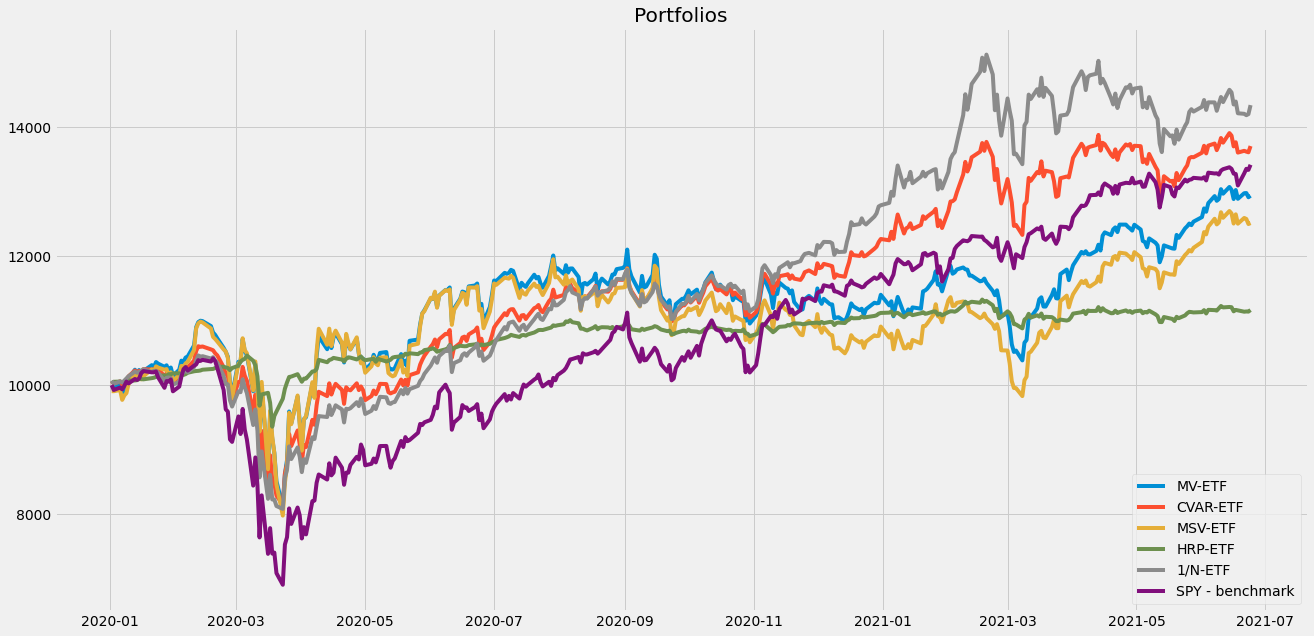

<Figure size 1440x720 with 0 Axes>

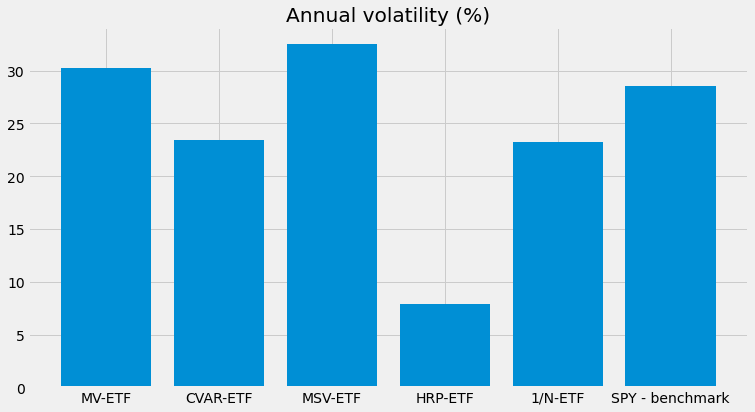

In [ ]:


plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')
for portfolio in portfolios:
  dates = [price.date for price in portfolio.current_value]
  prices = [price.value for price in portfolio.current_value]
  plt.plot(dates, prices)

plt.legend(portfolio_names + ["SPY - benchmark"], loc='lower right')
plt.title('Portfolios')
plt.show()

plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')

stdevs = []

for portfolio in portfolios:
  standard_deviations = statistics.stdev([price.value for price in portfolio.daily_procentual_change])
  annual_vol = standard_deviations * math.sqrt(252) 
  stdevs.append(annual_vol)  
  
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(portfolio_names + ["SPY - benchmark"], stdevs)
plt.title('Annual volatility (%)')
plt.show()